In [1]:
cd ..

/home/mars/src_aiai


In [2]:
import pickle
import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from src.visualisation import compare, print_statistics, plot_statistics
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error

In [5]:
import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 2
sns.set_context("notebook", font_scale=1.1)

In [17]:
data = "COCO"
ISNR = 30

In [18]:
metrics = [
    ("PSNR", peak_signal_noise_ratio),
    ("SSIM", structural_similarity),
    ("MSE", mean_squared_error)
]

In [33]:
results = [
    ("Pseudo-inverse", "PseudoInverse", ""),
    ("Primal-Dual", "PD", ""),     
    ("U-Net", "UNet", ""),      
    ("GU-Net", "GUnet", ""),
#     ("HL-Net", "highlow", ""),
]

In [9]:

def print_statistics(statistics, results, metrics, latex=False):
    if latex:
        separator = " & "
        lines = ""
    else:
        separator = "|"
        lines = "|"
    

    print( f"{'Name':40}", end=separator)
    for metric, f in metrics:
        print(f"{metric:20}", end=separator)
    if latex:
        print("\\\\", end="")
    print()
    for name, set, _ in sorted(results):
        if name in statistics.Method.values:
            print(f"{name+'_'+set:40}", end=separator)
            for metric, f in metrics:
                if latex:
                    print(f"$ {np.nanmean(statistics[metric][(statistics.Method == name) * (statistics.Set == set)]):8.3f} \pm {np.std(statistics[metric][(statistics.Method == name) * (statistics.Set == set)]):7.3f} $", end=separator)
                else:
                    print(f"{np.nanmean(statistics[metric][(statistics.Method == name) * (statistics.Set == set)]):8.3f} \pm {np.std(statistics[metric][(statistics.Method == name) * (statistics.Set == set)]):7.3f}", end=separator)
                
                # median = np.median(statistics[metric][(statistics.Method == name) * (statistics.Set == set)])
                # smad = 1.4826* np.median(np.abs(statistics[metric][(statistics.Method == name) * (statistics.Set == set)] - median))
                # print(f"{median:8.3f} \pm {smad:7.3f}|", end="")
            if latex:
                print("\\\\", end="")
            print()

In [10]:
def plot_statistics(statistics, metrics, ylims=[[0,40], [0,1], [0, 0.04]], split=True, order=None, save_base="./plots/violinplot"):
    #TODO add some better ytick labels, currently to many/much precision
    
    for idx, (metric, _) in enumerate(metrics):
        plt.figure(figsize=(8,6))
        sns.set_style('whitegrid')
        sns.violinplot(data=statistics, x='name', y=metric, split=split, hue='Set', palette="Set3", bw=.2, cut=1, linewidth=1, inner='quart', orientation='v', order=order)
        # sns.violinplot(data=statistics, x='Method', y=metric, split=False, hue='Set', palette="Set3", bw=.2, cut=1, linewidth=1, inner='quart', orientation='v')
        if metric == "PSNR":
            metric += " (dB)"
        plt.ylabel(metric, fontsize='x-large')
        plt.xlabel("")
        plt.tick_params(labelsize='x-large', rotation=90)
        # ax[idx].xaxis.label.set_size('x-large')
        sns.despine(left=False, bottom=False)
        plt.legend(loc="lower right", fontsize='large')
        plt.axis(ymin = ylims[idx][0], ymax=ylims[idx][1])
        plt.tight_layout()
        plt.savefig(save_base + f"_{idx+1}.pdf", transparent=True)
        plt.show()

In [169]:
for operator in ["NUFFT_SPIDER"]:
    statistics = pd.DataFrame(columns=["PSNR", "SSIM", "MSE", "method", "set"])

    for name, network, post in results:
        try:
            df = pd.read_csv(f"./results/{data}/{operator}/statistics_{network}_{ISNR}dB{post}.csv")
            df["name"] = name
            if statistics.empty:
                statistics = df
            else:
                statistics = statistics.append(df, ignore_index=False)
        except:
            pass
    with pd.option_context('mode.use_inf_as_na', True):
        statistics.dropna(inplace=True)

In [170]:
print_statistics(statistics, [(j, "train", k) for i,j,k in results], metrics, latex=True)

Name                                     & PSNR                 & SSIM                 & MSE                  & \\


In [171]:
print_statistics(statistics, [(j, "test", k) for i,j,k in results], metrics, latex=True)

Name                                     & PSNR                 & SSIM                 & MSE                  & \\


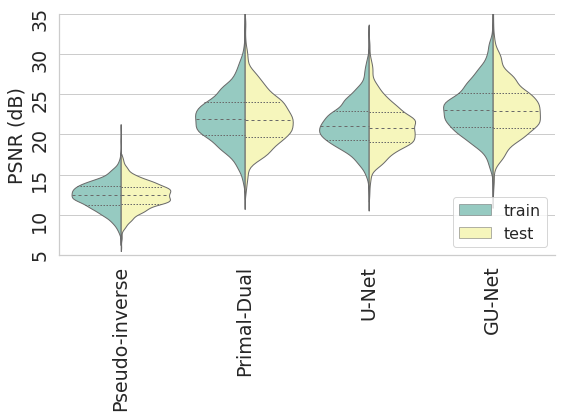

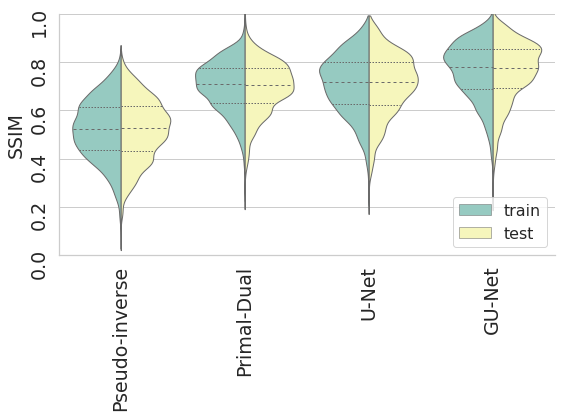

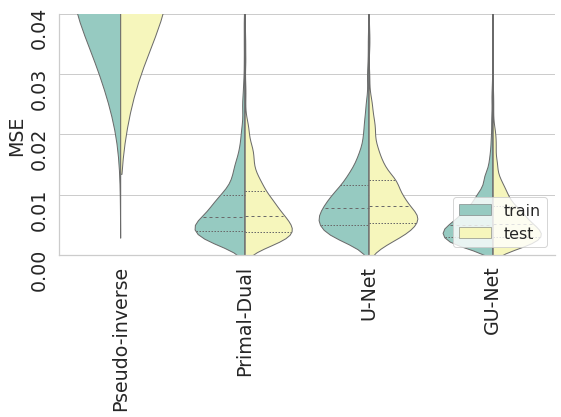

In [172]:
plot_statistics(statistics, metrics, save_base = "./plots/COCO_violin", ylims=[[5,35], [0,1], [0, 0.04]])#, order=["PseudoInverse", "PD", "UNet", "GUnet"])

In [173]:
operator = "NUFFT_SPIDER"

true = np.load(f"./data/intermediate/{data}/{operator}/x_true_test_30dB.npy")

res = [true[:5]]
titles = ["True"]

for name, network, post in results:
    try:
        ims = np.load(f"./data/processed/{data}/{operator}/test_predict_{network}_30dB{post}.npy")
        res.append(ims[:5])
        titles.append(name)
    except:
        pass

In [11]:
def compare_single(images, ncols=None, nrows=None, titles=None, same_scale=False, colorbar=False, cmap='viridis', save_base="./plots/example"):
    """[summary]
    TODO add colorbars
    Args:
        images ([type]): [description]
        ncols ([type], optional): [description]. Defaults to None.
        nrows ([type], optional): [description]. Defaults to None.
        titles ([type], optional): [description]. Defaults to None.
        same_scale (bool, optional): [description]. Defaults to False.
    """

    if not nrows:
        nrows = 1
    if not ncols:
        ncols = 1
    if ncols*nrows < len(images):
        ncols = len(images)
        nrows = 1
    if not titles:
        titles = [""]*len(images)

    for i in range(len(images)):
        plt.figure(figsize=(6,6))
        if i == 0:
            a = plt.imshow(images[0], cmap = cmap, vmin=0, vmax=1)    #todo remove hardcoded 0,1
            vmin, vmax = a.get_clim()
        elif same_scale:
            im = plt.imshow(images[i], vmin=vmin, vmax=vmax, cmap=cmap)
        else:
            im = plt.imshow(images[i], cmap=cmap)
        if i != 0:
            plt.title(titles[i] + f" (PSNR: {peak_signal_noise_ratio(images[0], images[i]):.2f}dB)" ) 
        else:
            plt.title(titles[i])
        if colorbar:
            plt.colorbar(fraction=0.046, pad=0.04)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.savefig(save_base + f"_{titles[i].split(' ')[0]}.pdf", transparent=True)
        plt.show()

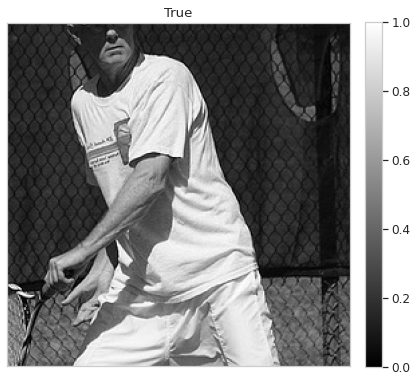

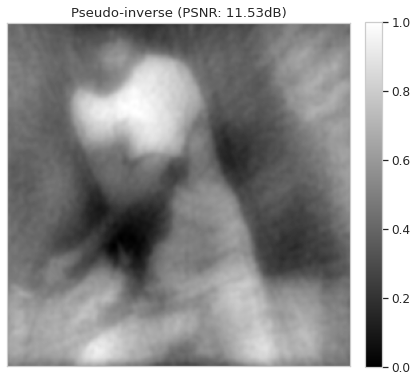

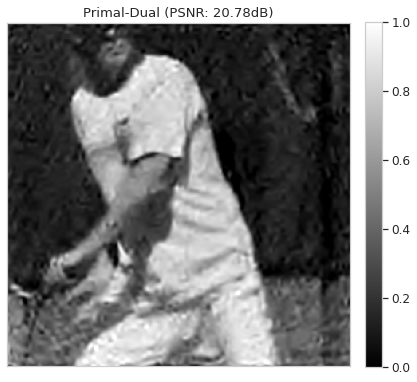

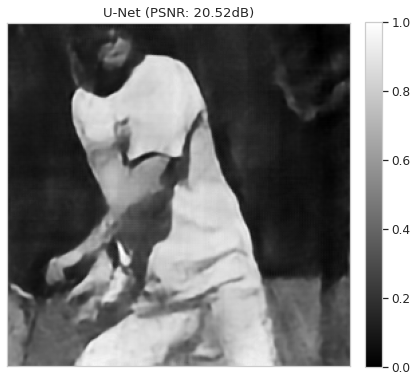

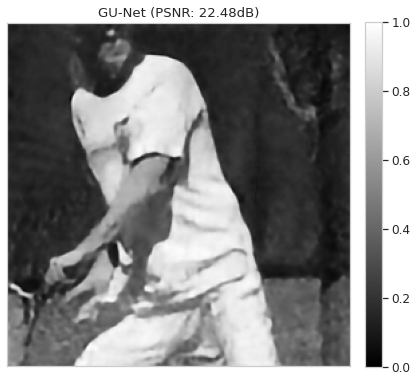

In [219]:
i = 4
compare_single(np.array(res)[:,i], titles=titles, nrows=3, ncols=3, colorbar=True, same_scale=True, cmap="gray", save_base="./plots/example_COCO")

# Computation times

In [34]:
begin = True
for name, net, post in results:
#     print(name, net, post)
    try: 
        summary = np.loadtxt(f"./results/COCO/{operator}/summary_{net}{post}.csv", delimiter=',', dtype=str)
        if begin:
            begin = False
            print(f"{'Name':25} & {summary[0,0] +' (ms)':20} & {summary[2,0]:20} & {summary[3,0]:20} & {summary[4,0]:20} \\\\")
        values = summary[:,1].astype(float)
        print(f"{name:25}& ${values[0]*1e3:8.3f} \pm {values[1]*1e3:<7.3f}$ & ${values[2]:20.0f}$ & ${values[3]:20.0f}$ & ${values[4]:20.0f}$ \\\\")
    except:
        pass
    
print(f"{'PD':25}& ${54.63289585908254*1e3:8.3e} \pm {5.557309727343783*1e3:<7.3e}$ & ${0:20.0f}$ & ${0:20.0f}$ & ${0:20.0f}$ \\\\")


Name                      & Mean time (ms)       & Total params         & Trainable params     & Non-trainable params \\
Pseudo-inverse           & $   0.285 \pm 22.212 $ & $                   0$ & $                   0$ & $                   0$ \\
U-Net                    & $   1.119 \pm 0.034  $ & $             2167649$ & $             2164193$ & $                3456$ \\
GU-Net                   & $   3.782 \pm 0.079  $ & $             2180897$ & $             2177441$ & $                3456$ \\
PD                       & $5.463e+04 \pm 5.557e+03$ & $                   0$ & $                   0$ & $                   0$ \\


In [26]:
a  = np.load("./data/processed/TNG/NUFFT_SPIDER/times_train_30dB.npy")

In [27]:
a.min()

45.51916456222534

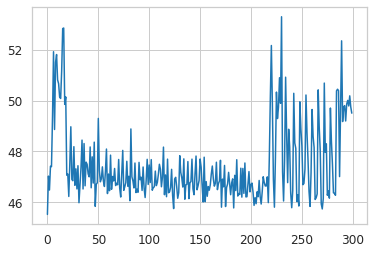

In [28]:
plt.plot(a)

In [31]:
np.median(a)

46.916818499565125

In [23]:
np.std(a)

1.48243082560678

# Robustness

In [24]:
operator = "NUFFT_SPIDER"

# results = []
# results += [(name, "Test", f"./data/processed/{data}/{operator}/test_predict_{net}_robustness{post}.npy") for name, net, post in name_net_post]

statistics = pd.DataFrame(columns=["PSNR", "SSIM", "MSE", "method", "set"])#{}

sigmas = np.repeat(np.arange(30,5,-2.5), 100)
x_test = np.load(f"./data/intermediate/{data}/{operator}/x_true_test_30dB_robustness.npy").reshape(-1,256,256)

for name, network, post in results[:-1]:
# for j in tqdm.tqdm(range(1)):

    try:
        pred = np.squeeze( np.load(f"./data/processed/{data}/{operator}/test_predict_{network}_30dB{post}_robustness.npy") )
        sigmas = sigmas.flatten()
        df = pd.DataFrame()
        for metric, f in metrics:
            x = x_test
            df[metric] = [f(x[i], pred[i]) for i in range(len(x))]
            df['Method'] = name
            df['Noise'] = sigmas
#             print(df)
        if statistics.empty:
            statistics = df
        else:
            statistics = statistics.append(df, ignore_index=False)
    #         examples.append((name, dset, pred[0]))
    except:
        pass


In [25]:
statistics_robustness = statistics

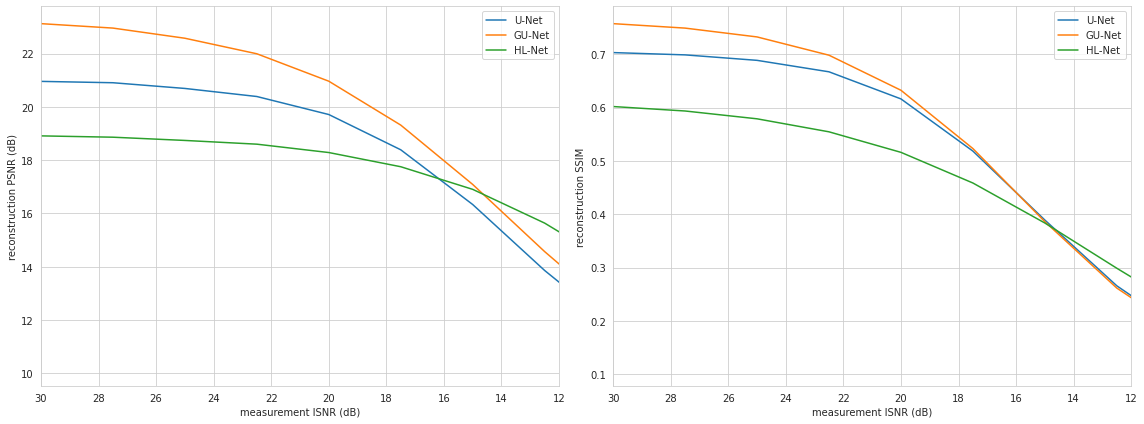

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

# plt.figure(figsize=(12,8))
i = 0
for name, network, post in results:
#     print(name, mode)
    mode = "Train"
    if mode == "Train":
        if True:
            sub = statistics_robustness[ statistics_robustness["Method"] ==  name].groupby("Noise").mean()
            std = statistics_robustness[ statistics_robustness["Method"] ==  name].groupby("Noise").std()
            
            if len(sub > 0) and name != 'Adjoint':
                ax[0].plot(np.arange(7.5, 32.5, 2.5), sub['PSNR'].values, color=f"C{i}", label = name)
#                 ax[0].fill_between(np.arange(7.5, 32.5, 2.5), sub['PSNR'].values-std['PSNR'].values, sub['PSNR'].values+std['PSNR'].values, color=f"C{i}", alpha=.3)

                ax[1].plot(np.arange(7.5, 32.5, 2.5), sub['SSIM'].values, color=f"C{i}", label = name)
#                 ax[1].fill_between(np.arange(7.5, 32.5, 2.5), sub['SSIM'].values-std['SSIM'].values, sub['SSIM'].values+std['SSIM'].values, color=f"C{i}", alpha=.3)
                i+= 1
                
#                 ax2 = ax[0].twiny()
#                 ax2.axis(xmin=fs.max(), xmax=fs.min())
#                 ax2.set_xticks(fs[::-1])
ax[0].axis(xmin=30, xmax=12)
ax[1].axis(xmin=30, xmax=12)
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel("measurement ISNR (dB)")
ax[0].set_ylabel("reconstruction PSNR (dB)")
ax[1].set_xlabel("measurement ISNR (dB)")
ax[1].set_ylabel("reconstruction SSIM")
plt.tight_layout()
plt.savefig("./plots/robustness.png")

some examples of predictions at different noise levels (using the last network which is the HL-net)

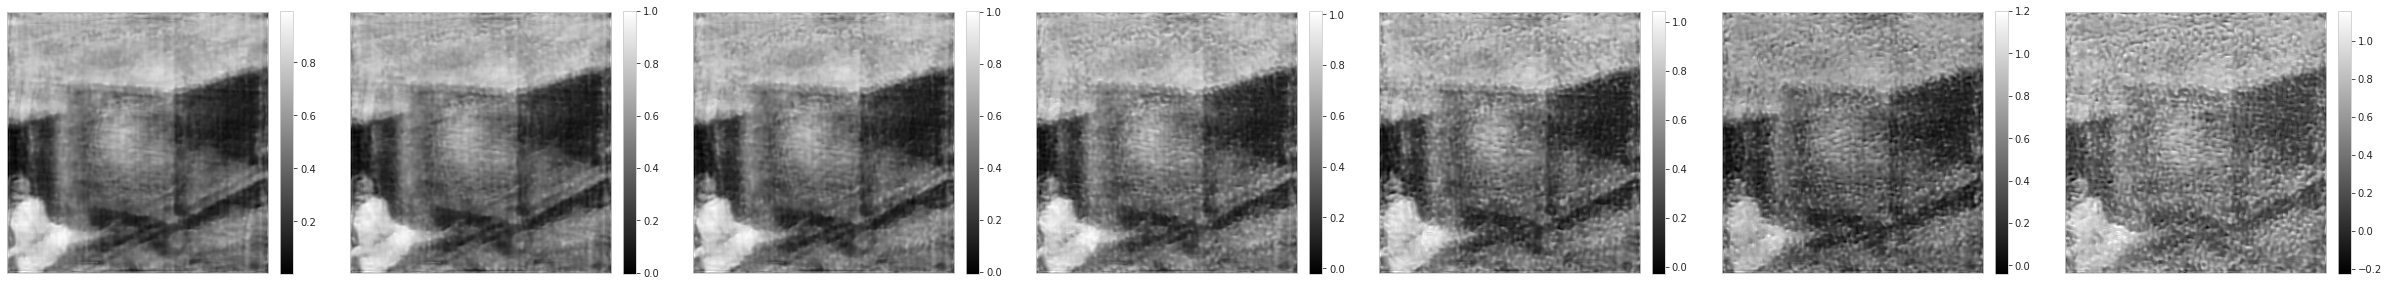

In [27]:
i = 2
compare([pred[i+j] for j in np.arange(0,700, 100)], ncols=2, colorbar=True, cmap='gray')

# Transfer learning TNG

In [12]:
data = "TNG"
operator="NUFFT_SPIDER"

In [13]:
results = [
#     ("Pseudo-Inverse", "PseudoInverse", "_TNG"),
    ("Primal-Dual", "PD", ""),
#     (f"{data}", "UNet", f"_{data}"),
#     ("COCO", "UNet", "_COCO"),
    ("U-Net", "UNet", "_transfer"),
    
#     (f"{data}", "GUnet", f"_{data}"),
#     ("COCO", "GUnet", "_COCO"),
    ("GU-Net", "GUnet", "_transfer"),


]

In [14]:
 [(j+f" {operator} {k[1:]}", "test", k) for i,j,k in results]

[('PD NUFFT_SPIDER ', 'test', ''),
 ('UNet NUFFT_SPIDER transfer', 'test', '_transfer'),
 ('GUnet NUFFT_SPIDER transfer', 'test', '_transfer')]

Name                                    |PSNR                |SSIM                |MSE                 |
GUnet_test                              |  38.859 \pm   2.119|   0.966 \pm   0.017|   0.000 \pm   0.000|
PD_test                                 |  38.104 \pm   2.497|   0.960 \pm   0.022|   0.000 \pm   0.000|
UNet_test                               |  32.688 \pm   2.898|   0.934 \pm   0.024|   0.001 \pm   0.001|


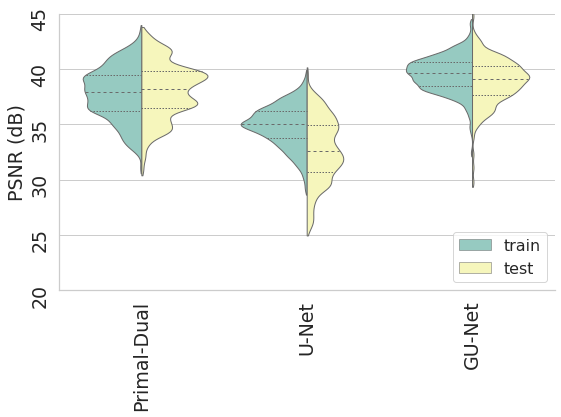

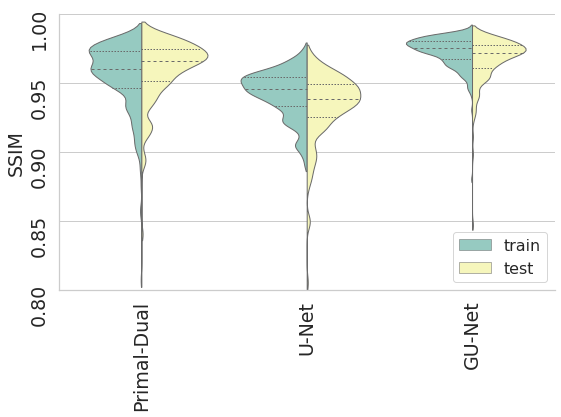

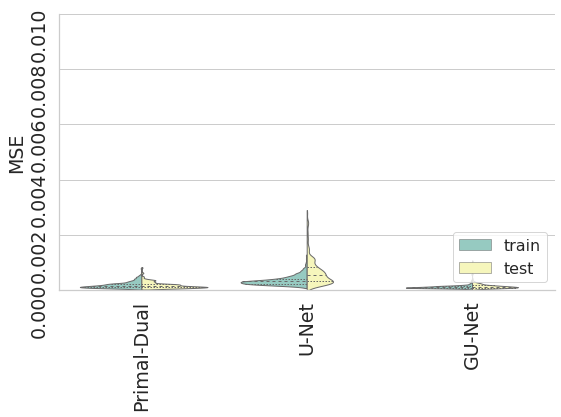

In [15]:
for operator in ["NUFFT_SPIDER"]:
    statistics = pd.DataFrame(columns=["PSNR", "SSIM", "MSE", "Method", "Set"])

    for name, network, post in results:
        try:
            df = pd.read_csv(f"./results/{data}/{operator}/statistics_{network}_30dB{post}.csv")
            df["name"] = name
            if statistics.empty:
                statistics = df
            else:
                statistics = statistics.append(df, ignore_index=False)
        except:
            pass
    with pd.option_context('mode.use_inf_as_na', True):
        statistics.dropna(inplace=True)
    statistics.Method = statistics.Method.map(lambda x: x.split(" ")[0])
    print_statistics(statistics, [(j, "test", k) for i,j,k in results], metrics)
    plot_statistics(statistics, metrics, ylims=[[20,45], [0.8,1], [0, 0.01]], save_base="./plots/violin_TNG")#, order=["Pseudo-inverse", "Primal Dual", "U-net", "GU-net"])

In [202]:
results = [
    ("PseudoInverse", "PseudoInverse", f"_{data}"),
    
    ("Primal-Dual", "PD", ""),

    
    (f"UNet_{data}", "UNet", f"_{data}"),
    ("UNet_COCO", "UNet", "_COCO"),
    ("UNet_Transfer", "UNet", "_transfer"),
    
    (f"GUnet_{data}", "GUnet", f"_{data}"),
    ("GUnet_COCO", "GUnet", "_COCO"),
    ("GUnet_Transfer", "GUnet", "_transfer"),
]

In [203]:
operator = "NUFFT_SPIDER"

true_random = np.load(f"./data/intermediate/{data}/{operator}/x_true_test_30dB.npy")

res_random = [true_random[:5]]
titles_random = ["True"]

for name, network, post in results:
    try:
        ims = np.load(f"./data/processed/{data}/{operator}/test_predict_{network}_30dB{post}.npy")
        res_random.append(ims[:5])
        titles_random.append(name)
    except:
        pass

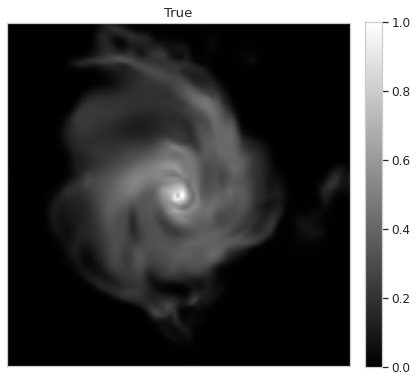

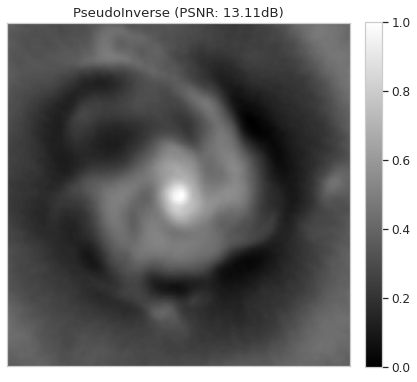

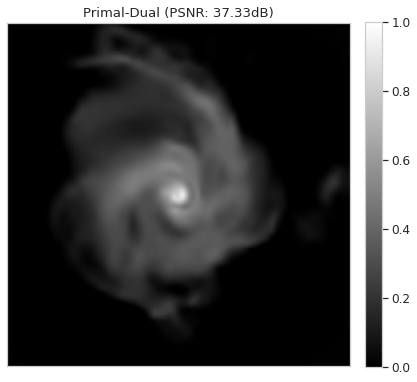

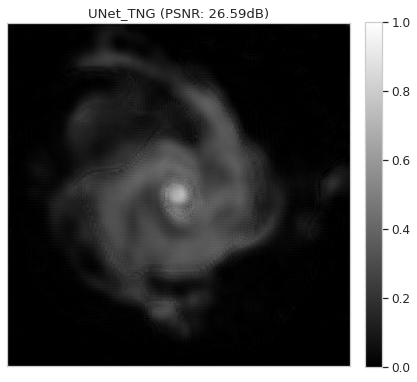

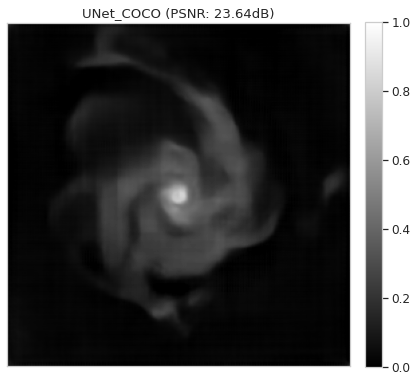

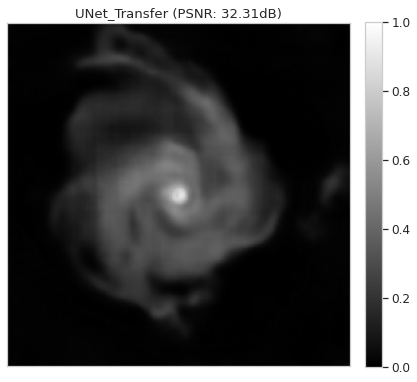

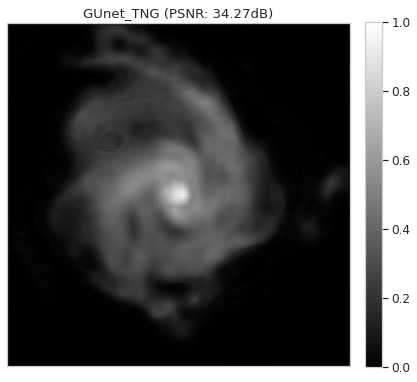

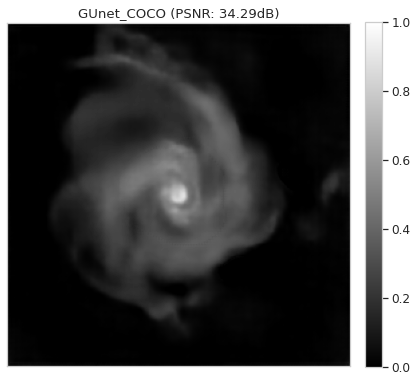

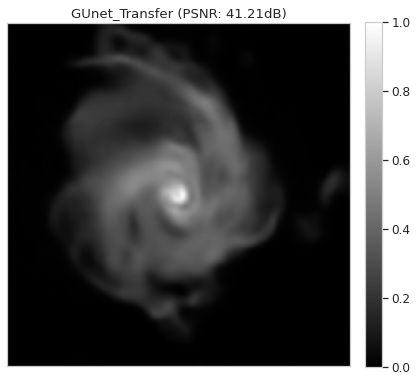

In [204]:
i = 3
compare_single(np.array(res_random)[:,i], titles=titles_random, nrows=3, ncols=3, colorbar=True, same_scale=True, cmap="gray", save_base="./plots/example_TNG")

# SATS

In [205]:
data = "SATS"
operator="NUFFT_SPIDER"

In [206]:
results = [
#     ("PseudoInverse", "PseudoInverse", f"_{data}"),

    ("Primal-Dual", "PD", ""),

    
#     (f"{data}", "UNet", f"_{data}"),
#     ("COCO", "UNet", "_COCO"),
    ("U-Net", "UNet", "_transfer"),
    
#     (f"{data}", "GUnet", f"_{data}"),
#     ("COCO", "GUnet", "_COCO"),
    ("GU-Net", "GUnet", "_transfer"),


]

In [207]:
 [(j+f" {operator} {k[1:]}", "test", k) for i,j,k in results]

[('PD NUFFT_SPIDER ', 'test', ''),
 ('UNet NUFFT_SPIDER transfer', 'test', '_transfer'),
 ('GUnet NUFFT_SPIDER transfer', 'test', '_transfer')]

Name                                     & PSNR                 & SSIM                 & MSE                  & \\
GUnet_test                               & $   28.368 \pm   3.553 $ & $    0.822 \pm   0.076 $ & $    0.002 \pm   0.002 $ & \\
PD_test                                  & $   22.813 \pm   2.089 $ & $    0.738 \pm   0.061 $ & $    0.006 \pm   0.003 $ & \\
UNet_test                                & $   26.116 \pm   3.527 $ & $    0.793 \pm   0.091 $ & $    0.003 \pm   0.003 $ & \\


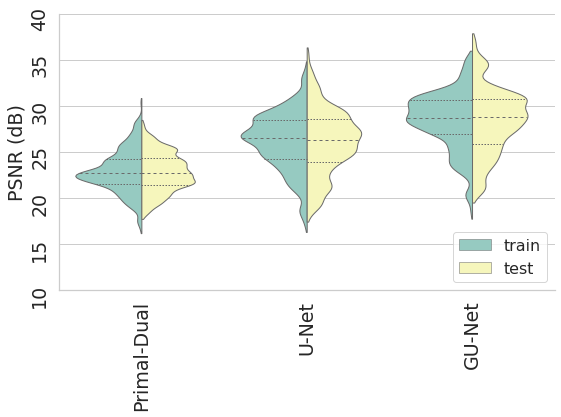

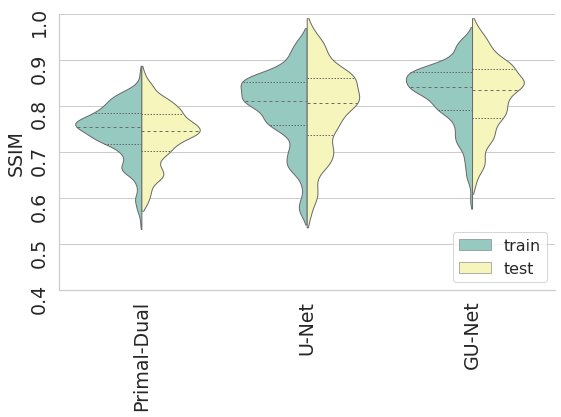

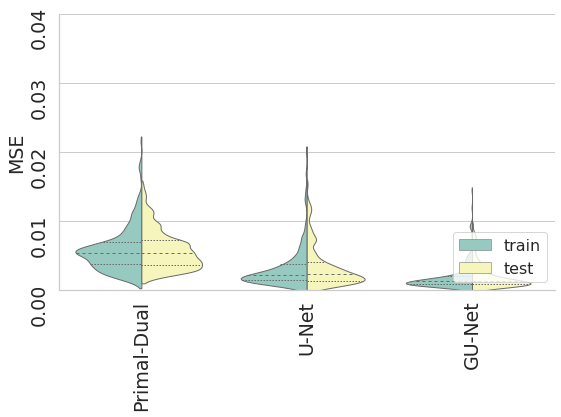

In [208]:
for operator in ["NUFFT_SPIDER"]:
    statistics = pd.DataFrame(columns=["PSNR", "SSIM", "MSE", "Method", "Set"])

    for name, network, post in results:
        try:
            df = pd.read_csv(f"./results/{data}/{operator}/statistics_{network}_30dB{post}.csv")
            df['name'] = name
            if statistics.empty:
                statistics = df
            else:
                statistics = statistics.append(df, ignore_index=False)
        except:
            pass
    with pd.option_context('mode.use_inf_as_na', True):
        statistics.dropna(inplace=True)
    statistics.Method = statistics.Method.map(lambda x: x.split(" ")[0])

    print_statistics(statistics, [(j, "test", k) for i,j,k in results], metrics, latex=True)
    plot_statistics(statistics, metrics, ylims=[[10,40], [0.4,1], [0, 0.04]], save_base="./plots/violin_SATS")#, order=["Pseudo-inverse", "Primal Dual", "U-net", "GU-net"])

In [209]:
set(list(statistics.Method))

{'GUnet', 'PD', 'UNet'}

In [210]:
results = [
    ("PseudoInverse", "PseudoInverse", f"_{data}"),
    
    ("Primal-Dual", "PD", ""),

    
#     (f"UNet {data}", "UNet", f"_{data}"),
#     ("UNet COCO", "UNet", "_COCO"),
    ("U-Net", "UNet", "_transfer"),
    
#     (f"GUnet {data}", "GUnet", f"_{data}"),
#     ("GUnet COCO", "GUnet", "_COCO"),
    ("GU-Net", "GUnet", "_transfer"),
]

In [211]:
operator = "NUFFT_SPIDER"

true_random = np.load(f"./data/intermediate/{data}/{operator}/x_true_test_30dB.npy")

res_random = [true_random[:5]]
titles_random = ["True"]

for name, network, post in results:
    try:
        ims = np.load(f"./data/processed/{data}/{operator}/test_predict_{network}_30dB{post}.npy")
        res_random.append(ims[:5])
        titles_random.append(name.split(" ")[0])
    except:
        pass

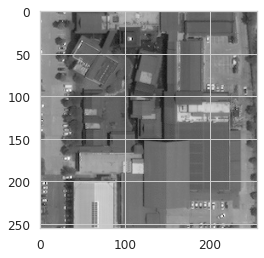

In [215]:
plt.imshow(np.array(res_random)[0,i], vmin=0, vmax=1, cmap="gray")

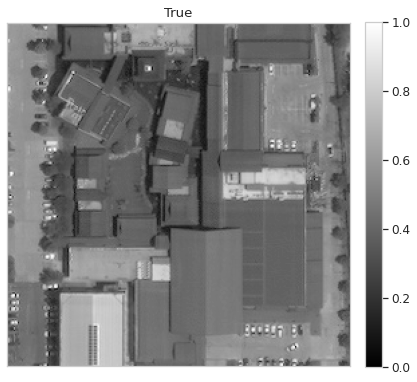

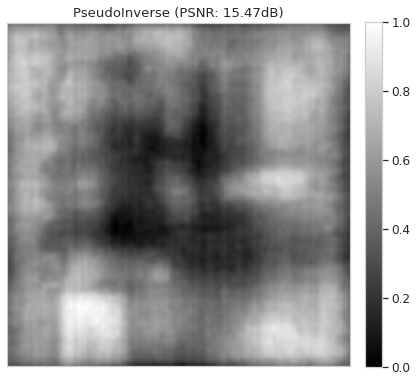

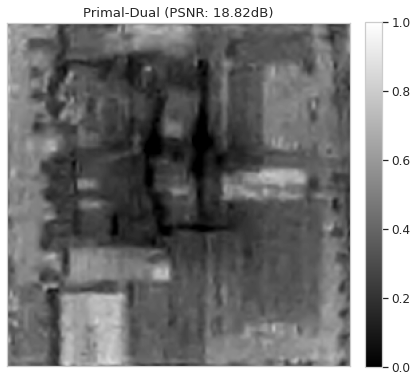

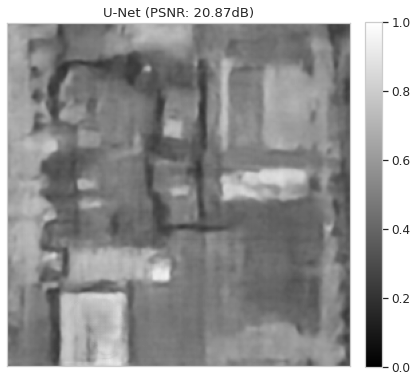

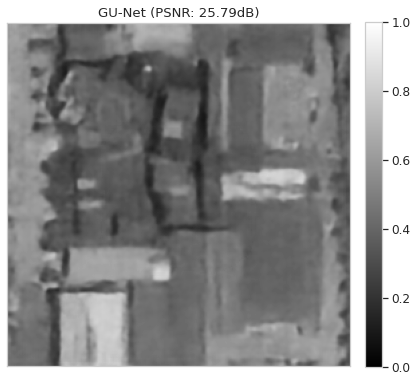

In [220]:
i = 2
compare_single(np.array(res_random)[:,i], titles=titles_random, nrows=3, ncols=3, colorbar=True, same_scale=True, cmap="gray",save_base="./plots/example_SATS")